## Netflix has been booming lately and it has become one of the biggest online movies and tv shows streaming platform. This dataset provides crucial insights of the contents provided by Netflix. Let's start exploring and learning together!

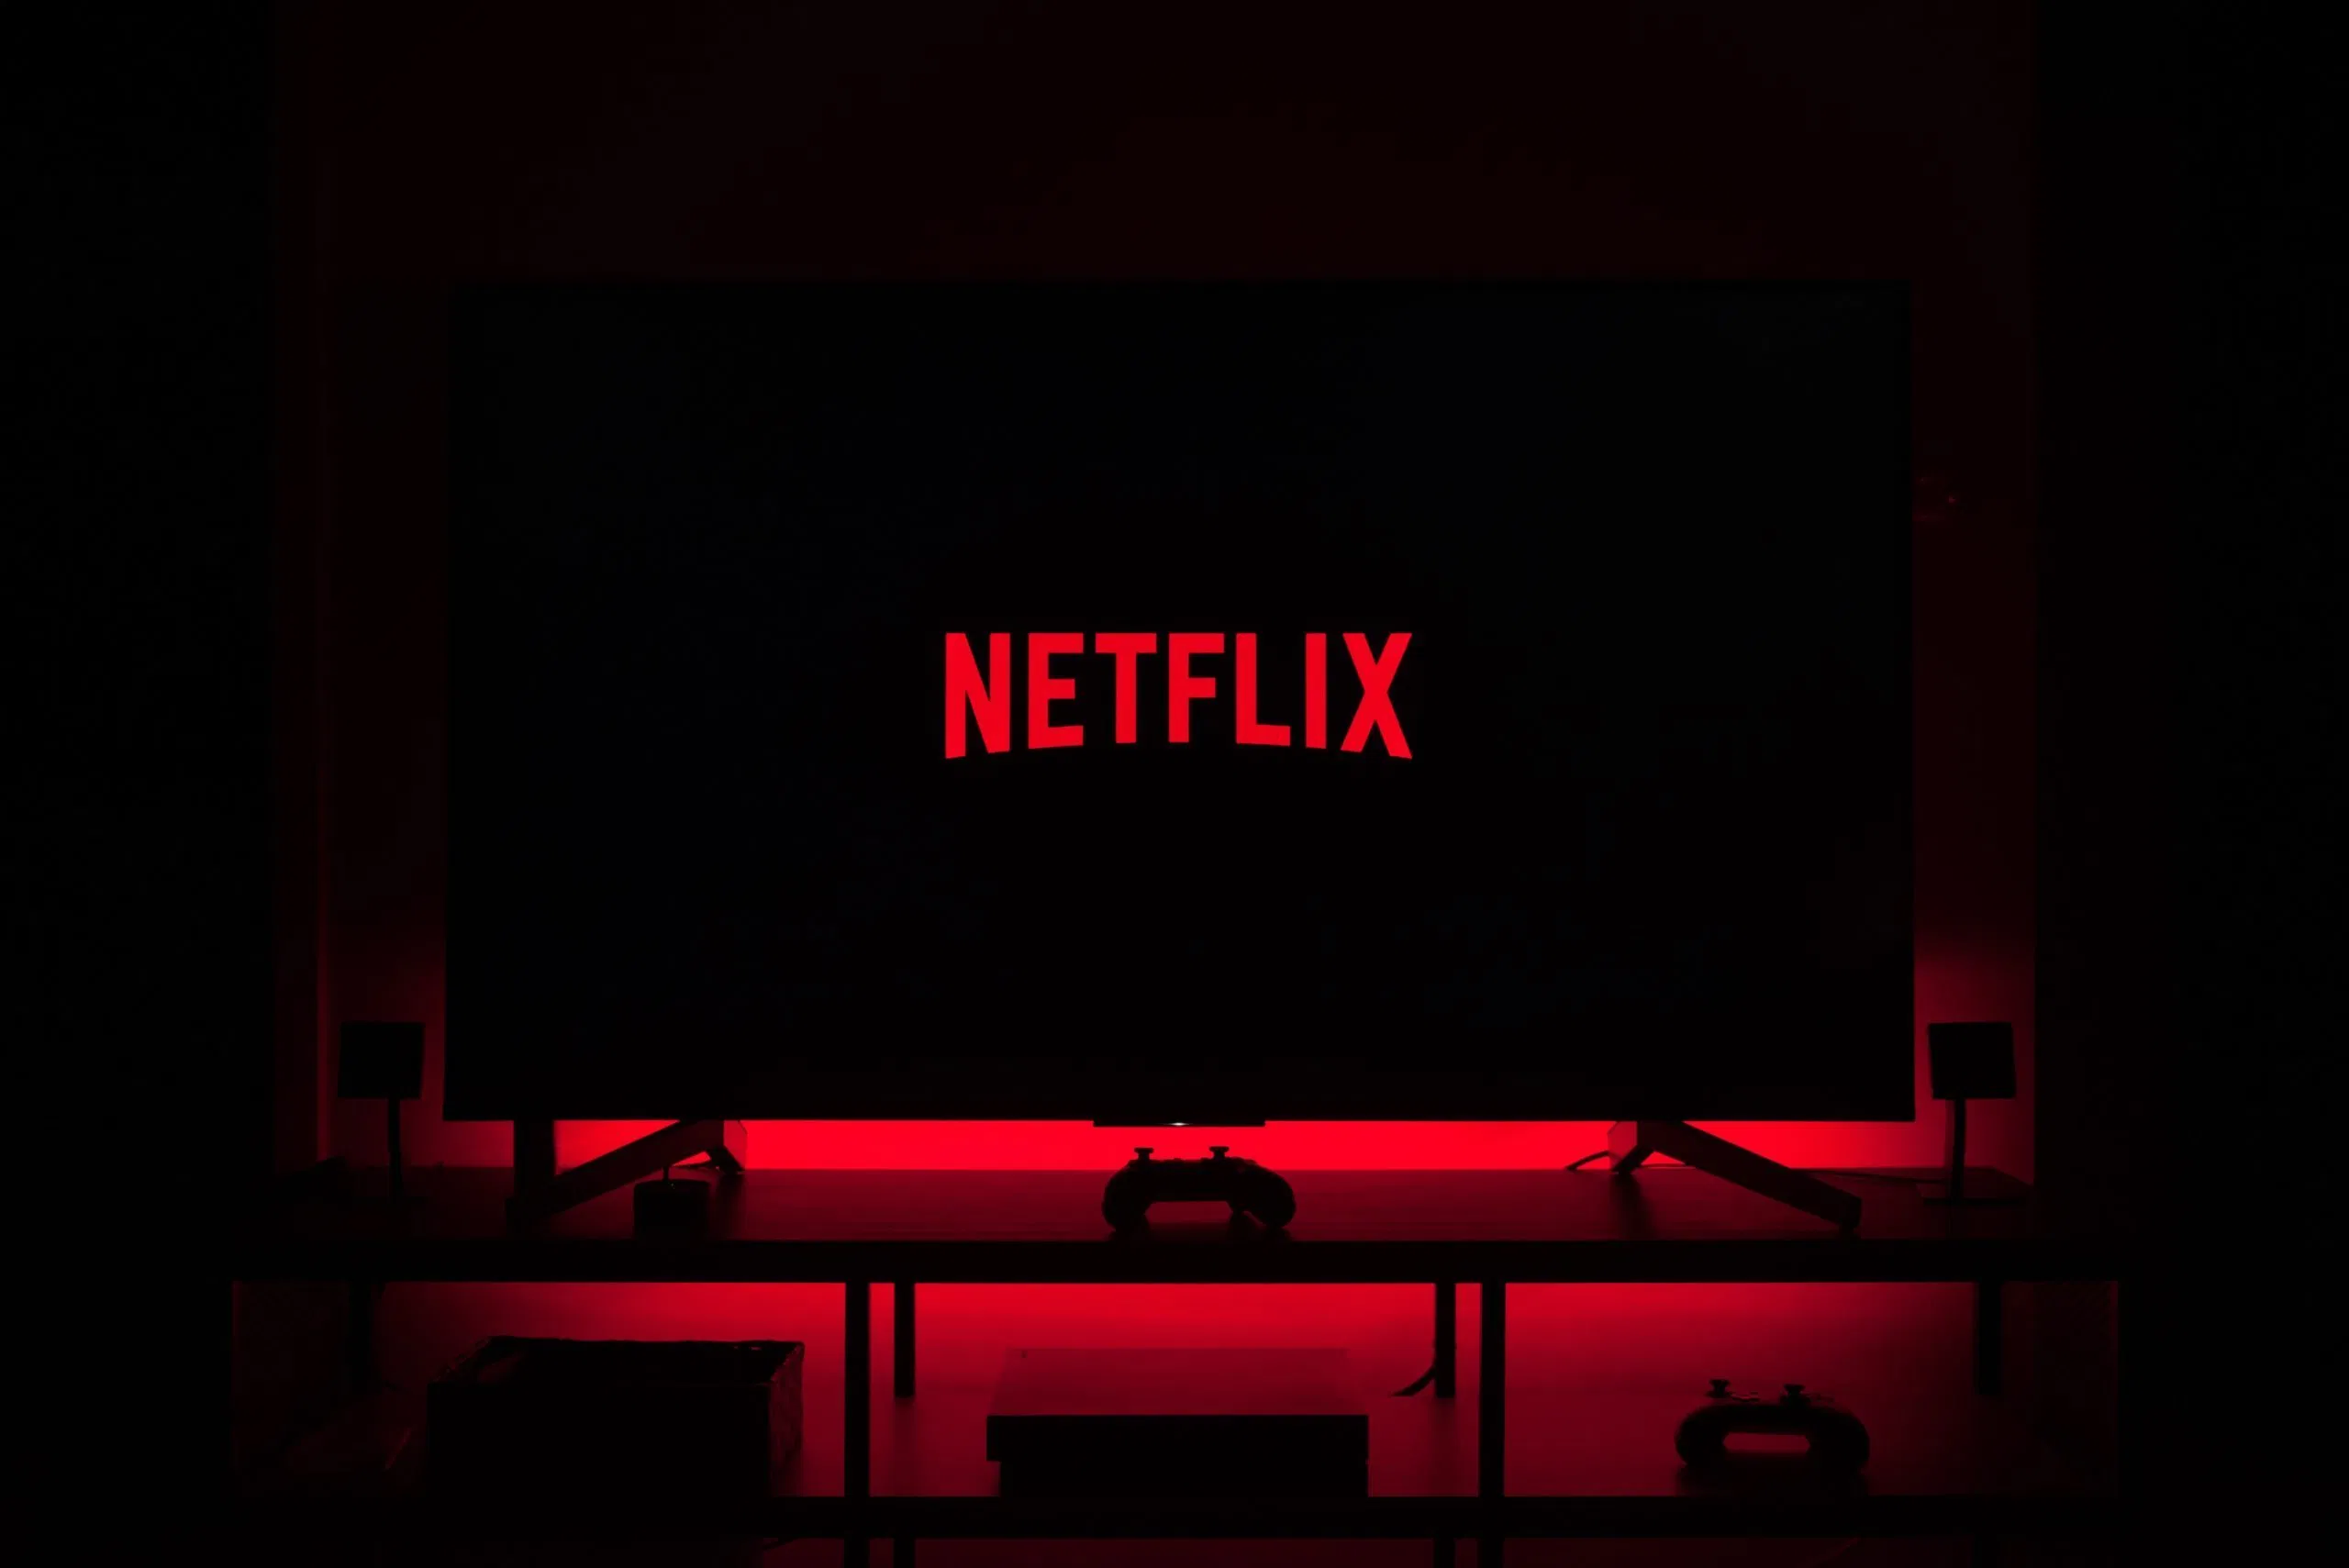

In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import seaborn as sns

## Get to know the datas

In [ ]:
df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
df.head()

__1. Checking the size of the dataset__

In [ ]:
df.shape

__2.Check if there is any duplicated records__

In [ ]:
df.duplicated().any()

__3.Look at some basic information of the dataset, and we can see 11 of the datatype are object and 1 is integer.__

In [ ]:
df.info()

__4.Number of unique data for each column__

In [ ]:
df.nunique()

__5.Percentage of unique data for each column__

In [ ]:
df.nunique() / df.shape[0] * 100

__6.Checking for missing / null value for each column. Director, cast, country, date_added, rating have missing values__

In [ ]:
df.isnull().sum()

__7.A heatmap showing the missing values__

In [ ]:
sns.heatmap(df.isnull(),cmap = 'inferno')

__8.Check the percentage of missing values for each column.__
- director: This column can be deleted since it has about 30% missing values and about 52% of unique data, hence it does not provide much information for our analysis. However, it will be important for recommender system 
- cast: This column can be deleted too since it has about 9% missing values and about 88% of unique data, hence is also does not provide significant information for analysis. However, it will be important for recommender system 
- country: We replace the missing values with 'United States' since Netflix is originated from United States and most of the movies and TV shows are aired in there. Statistically, looking at the mode of the country column also confirm that 'United States' can be a great replacement for the missing values. 
- date_added:  Since the missing number is small, we can either delete of the missing rows or we can use a little effort to scrape the data from the Internet. 
- rating: Since the missing number is small, we can either delete of the missing rows or we can use a little effort to scrape the data from the Internet. 



In [ ]:
df.isnull().sum() / df.shape[0] * 100

## Data Preprocessing and Handling Missing Data

__1.Deleting 'director' and 'cast' column__

In [ ]:
df.drop(['director','cast'], axis=1 ,inplace=True)
df.head()

__2.Filling the missing 'country' value with 'United States'__

In [ ]:
df['country'].fillna('United States', inplace=True)
df['country'].isnull().any()

__3.Since the 'date_added' data for the missing values are not readily avaialble on the Internet, I choose to drop the missing rows.__

In [ ]:
df.dropna(subset=['date_added'],axis = 0, inplace = True)
df['date_added'].isnull().any()

In [ ]:
df['rating'].unique()

__4.Checking the missing 'rating' movie title and search their 'rating' on Internet__

In [ ]:
df[df['rating'].isnull()]

   __5. Replacing the missing 'rating' values which are found from IMDb and Netflix.__

In [ ]:
rating_replacements = {67: 'TV-PG', 2359: 'TV-14', 3660: 'TV-MA', 3736: 'TV-MA', 3737: 'TV-MA', 3738: 'TV-MA', 4323: 'PG-13'}
for index, rating in rating_replacements.items():
    df.loc[index, 'rating'] = rating
df['rating'].isnull().any()

__6. Adding new features__

- We can add new features from the date_added column which are month and year. Also, we can split the duration column into 'season_count' and 'duration'. 'principal_country' is a column containing the first country listed on 'country' column because some of the content are released by multiple countries.

In [ ]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['season_count'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
df['duration_in_min'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])

- Adding a new column 'target_ages' based on the content 'rating'.

In [ ]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
df['target_ages'] = df['rating'].replace(ratings_ages)
df.head()

## Data Visualization(Exploratory Data Analysis)

__Before we start our exploratory data analysis, we should ask some question we are interested in and use the power of visualization to help us understand and answer our question.__
__Some interesting questions:__
1. Does Netflix contains more TV shows or movies?
2. Which country produce the most content?
3. Is the rate of content addition increasing over the year?
4. Which are the most favoured genre?
5. Does kids prefer TV show or movies?

#### 1. What is the composition of Netflix content?

In [ ]:
pie_x = df['type'].value_counts().reset_index()
pie_x = pie_x.rename(columns={'index':'type','type':'count'})

trace = go.Pie(labels=pie_x['type'], values=pie_x['count'], pull=[0.05])
layout = go.Layout(title="", height=450, legend=dict(x=0.1, y=1))
fig = go.Figure(data = [trace], layout = layout)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

- The movies accounts for 69.1% of the content, which is the majority.

#### 2. Is the rate of addition of movie greater than tv shows or vice versa?

In [ ]:
tv_show = df[df["type"] == "TV Show"]
movie = df[df["type"] == "Movie"]


tv_show_count = tv_show['year_added'].value_counts().reset_index()
tv_show_count = tv_show_count.rename(columns={'index': 'year_added', 'year_added': 'count'})
tv_show_count = tv_show_count.sort_values('year_added')

movie_count = movie['year_added'].value_counts().reset_index()
movie_count = movie_count.rename(columns= {'index': 'year_added', 'year_added': 'count'})
movie_count = movie_count.sort_values('year_added')

trace1 = go.Scatter(x=tv_show_count['year_added'], y=tv_show_count['count'], name="TV Shows")
trace2 = go.Scatter(x=movie_count['year_added'], y=movie_count["count"], name="Movies")
data = [trace1, trace2]
layout = go.Layout(title="Content added over the years",xaxis_title='Year',yaxis_title='count', legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

- Initially, the rate of addition of TV shows and movies seems to be at the same pace. 
- From 2016 to 2018, a total of 2377 movies have been added while only 976 TV shows have been added
- In 2020, there is a slight increase in the rate of addition of TV shows and a slight reduction in rate of addition of movies which may be a factor of the COVID-19 pandemic.

#### 3. Which month contributes most to content update?

In [ ]:

month_order = [1,2,3,4,5,6,7,8,9,10,11,12][::-1]
month_HM = df.groupby('year_added')['month_added'].value_counts().unstack().fillna(0)[month_order].T
plt.figure(figsize=(10, 5), dpi=300)
plt.pcolor(month_HM, cmap='afmhot_r', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(month_HM.columns), 1), month_HM.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(month_HM.index), 1), month_HM.index, fontsize=7, fontfamily='serif')
plt.title('Netflix Monthly Contents Update', fontsize=12, fontweight='bold', position=(0.40, 1.0+0.02))
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=8) 
cbar.ax.minorticks_on()
plt.show()


- This heatmap shows that there are more contents being added during the last few months compare to other months.
- This heatmap might not be the best visualization tool to illustrate the question above but I want to learn to plot more different graphs. A bar chart might better visualize the differences. 

#### 4. Do kids prefer TV shows or movies?

In [ ]:
def generate_rating_df(df):
    rating_df = df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts']
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

In [ ]:
movie_rating_df = generate_rating_df(df[df['type'] == 'Movie'])
show_rating_df = generate_rating_df(df[df['type'] == 'TV Show'])

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=movie_rating_df['target_ages'], values=movie_rating_df['counts']),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=show_rating_df['target_ages'], values=show_rating_df['counts']),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Ages based rating distribution by type of content",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Movies', x=0.20, y=0.5, font_size=12, showarrow=False),
                 dict(text='TV Shows', x=0.82, y=0.5, font_size=12, showarrow=False)])
fig.show()

- Movies has about 5.7% more adult content than TV shows.
- TV shows has 30% of content for kids+older kids while movie has only 20%.
- Based on the findings, we can assume that kids prefer TV shows.

#### 5. What does the distribution of rating for TV show and movies look like?

In [ ]:
rating_order =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']
m1 = {'rating': 'G', 'count': 0}
m2 = {'rating': 'NC-17', 'count': 0}
m3 = {'rating': 'PG', 'count': 0}
m4 = {'rating': 'PG-13', 'count': 0}
movie = df[df['type'] == 'Movie']
tv_show = df[df['type'] == 'TV Show']
movie_rating = movie['rating'].value_counts()[rating_order]
tv_rating = tv_show['rating'].value_counts().reset_index()
tv_rating = tv_rating.rename(columns={'index': 'rating','rating': 'count'})
tv_rating = tv_rating.append(m1,ignore_index=True)
tv_rating = tv_rating.append(m2,ignore_index=True)
tv_rating = tv_rating.append(m3,ignore_index=True)
tv_rating = tv_rating.append(m4,ignore_index=True)

tv_rating = tv_rating.set_index('rating')
tv_rating = tv_rating.T
tv_rating = tv_rating[rating_order]
tv_rating = tv_rating.iloc[0]


In [ ]:
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#d0d0d0", width=0.6, edgecolor='black')

    color =  ['green',  'blue',  'orange',  'red']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.1)

    ax.set_title(f'Distribution of {title} Rating', fontsize=20, fontweight='bold', position=(0.5, 1.0+0.03))
    plt.show()

In [ ]:
rating_barplot(movie_rating,'Movie', 1500)

- TV-MA is the most popular rating for Mature movie, and for teens movie, TV-14 has about 3 times more than PG-13 movie.


In [ ]:
rating_barplot(tv_rating,'TV Show' , 700)

- For TV show, TV-MA also dominates the Mature content.

#### 6. Which country produces the most content?

In [ ]:
country_df = df['principal_country'].value_counts().reset_index()
country_df = country_df[country_df['principal_country'] /  country_df['principal_country'].sum() > 0.01]
country_df = country_df.rename(columns={'index': 'country', 'principal_country': 'count'})
country_df = country_df.sort_values('count')

In [ ]:
trace1 = go.Bar(y=country_df['country'], x=country_df['count'], orientation="h", name="")

data = [trace1]
layout = go.Layout(title="Countries with most content",xaxis_title='count', height=700, legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

- United States, India and United Kingdom is the top 3 countries with the most content.
- As an aspired producer or actor/actress, you might consider this 3 countries for your career.

#### 7. What does the content cumulation over the year look like on a world map?

In [ ]:
country_df2 = df.groupby(['year_added','principal_country']).agg({'show_id': 'count'}).reset_index()
country_df2['aggregate'] = country_df2.groupby(['principal_country'])['show_id'].cumsum()



In [ ]:

# year_country2 = data2.groupby('year_added')['country'].value_counts().reset_index(name='counts')

fig = px.choropleth(country_df2, locations="principal_country", color="aggregate", 
                    locationmode='country names',
                    animation_frame='year_added',
                    range_color=[0,200],
                    color_continuous_scale=px.colors.sequential.OrRd
                   )

fig.update_layout(title='Cumulative sum of content over the year by country')
fig.show()

- We can see that the North America, India and Europe dominates the content cumulation over the year.

#### 8. What is the range of movie duration for most of movies?

In [ ]:
df.dtypes

In [ ]:

x1 = movie['duration_in_min'].fillna(0.0).astype(float)
fig = ff.create_distplot([x1], [''], bin_size=0.7, curve_type='normal')
fig.update_layout(title_text='Distplot with Normal Distribution',xaxis_title = 'duration in min', yaxis_title='PDF')
fig.show()

- The duration for movies are distributed normally where the peak are in the range between 90 and 100 minutes.

#### 9. Does TV show usually have more than one season?

In [ ]:
bar_season = tv_show['season_count'].value_counts().reset_index()
bar_season = bar_season.rename(columns = {'season_count' : "count", "index" : 'season_count'})
bar_season['season_count'] = pd.to_numeric(bar_season['season_count'])
bar_season = bar_season.sort_values('season_count')

trace1 = go.Bar(x=bar_season['season_count'], y=bar_season["count"], name="TV Shows")
data = [trace1]
layout = go.Layout(title="Seasons for TV Show",yaxis_title = 'count',xaxis_title='Number of Seasons', legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

- Most of the TV show consist of 1 season only.

#### 10. What are the favourite genre of movies and TV shows respectively?

In [ ]:
from collections import Counter
col = "listed_in"
categories = ", ".join(movie['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows")

data = [trace1]
layout = go.Layout(title="Genre distributions of movies",xaxis_title='count', legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

- The top 3 favourite genre of movies are:
    1. International movies
    2. Dramas
    3. Comedies
 

In [ ]:
col = "listed_in"
categories = ", ".join(tv_show['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows")

data = [trace1]
layout = go.Layout(title="Genre distributions of TV Show",xaxis_title='count', legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

- The top 3 favourite TV shows genre are:
    1. International TV Shows
    2. TV Dramas
    3. TV Comedies

#### 11. What are the usual keywords in the movie genre?

In [ ]:
from wordcloud import WordCloud
categories = ", ".join(movie['listed_in']).split(", ")
text = str(categories).replace(',','').replace('[','').replace("''",'').replace(']','')

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 12. What are the 20 oldest movies and TV shows on Netflix?

In [ ]:
movie_asc = movie.sort_values("release_year", ascending = True)

movie_asc[['title', "release_year"]][:20]

In [ ]:
tv_asc = tv_show.sort_values("release_year", ascending = True)

tv_asc[['title', "release_year"]][:20]

#### 13. What is the favourite genre for movie from year 2017 onwards?

In [ ]:
movie['genre'] = movie['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
movie['principal_genre'] = movie['genre'].apply(lambda genres: genres[0])
top_movies_genres = [
    'International Movies',
    'Dramas',
    'Comedies'
]

In [ ]:
year_genre_df = movie[(movie['principal_genre'].isin(top_movies_genres)) & (movie['year_added'] >= 2017)].groupby(['principal_genre', 'year_added']).agg({'title': 'count'})
year_genre_df = year_genre_df.reset_index()
year_genre_df.columns = ['principal_genre', 'year_added', 'count']

fig = px.sunburst(year_genre_df, path=['year_added', 'principal_genre'], values='count')
fig.show()

- Again, this might not be the best visualization for the question, but I take this as a lesson to learn more visualization tools.

## Thank you for reading my first ever notebook!! Your feedback and upvote is very much appreciated. 

### Here are some notebooks I have referenced for this project(shoutout to the authors), do check them out!
 - https://www.kaggle.com/subinium/storytelling-with-data-netflix-ver/data
 - https://www.kaggle.com/shivamb/netflix-shows-and-movies-exploratory-analysis/notebook
 - https://www.kaggle.com/niharika41298/netflix-visualizations-recommendation-eda#Recommendation-System-(Content-Based)
 - https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly/data